## Imports

In [1]:
import wandb
import os
import multiprocessing
import rasterio
import tensorflow as tf
from glob import glob
import pickle
import numpy as np
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow_addons.metrics import F1Score, HammingLoss
from tensorflow_addons.losses import SigmoidFocalCrossEntropy

from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import boto3
import io
from test_generator import TestGenerator
np.set_printoptions(suppress=True)
np.set_printoptions(precision=6)

In [2]:
print(tf.__version__)

2.4.0


## Evaluation

#### Variables definition

In [3]:
label_list = ["Habitation", "ISL", "Industrial_agriculture", "Mining", "Rainforest", "River", "Roads", "Savannah", 
              "Shifting_cultivation", "Water"]
numclasses = len(label_list)
bands_all = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17, 18]
bands_RGBNIRN = [2, 3, 4, 8, 18]
input_shape_all_bands= (100,100,len(bands_all))
input_shape_RGBNIRN = (100,100,len(bands_RGBNIRN))


#### Define model (same architecture as the one used for the training)

In [4]:
def define_model(numclasses,input_shape,starting_checkpoint=None,lcl_chkpt_dir=None):
        # parameters for CNN
        input_tensor = Input(shape=input_shape)

        # introduce a additional layer to get from bands to 3 input channels
        input_tensor = Conv2D(3, (1, 1))(input_tensor)

        base_model_resnet50 = keras.applications.ResNet50(include_top=False,
                                  weights='imagenet',
                                  input_shape=(100, 100, 3))
        base_model = keras.applications.ResNet50(include_top=False,
                         weights=None,
                         input_tensor=input_tensor)

        for i, layer in enumerate(base_model_resnet50.layers):
            # we must skip input layer, which has no weights
            if i == 0:
                continue
            base_model.layers[i+1].set_weights(layer.get_weights())

        # add a global spatial average pooling layer
        top_model = base_model.output
        top_model = GlobalAveragePooling2D()(top_model)

        # let's add a fully-connected layer
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        # and a logistic layer
        predictions = Dense(numclasses, activation='sigmoid')(top_model)

        # this is the model we will train
        model = Model(inputs=base_model.input, outputs=predictions)
    #     model = model.layers[-1].bias.assign([0.0]) # WIP getting an error ValueError: Cannot assign to variable dense_8/bias:0 due to variable shape (10,) and value shape (1,) are incompatible

#         model.summary()
        if starting_checkpoint:
            s3 = boto3.resource('s3')
            chkpt_name = lcl_chkpt_dir + '/' + 'start_chkpt.h5'
            s3.download_file('canopy-production-ml-output', starting_checkpoint, chkpt_name)
            model.load_weights(chkpt_name)
    
        return model

In [5]:
model_all_bands = define_model(numclasses, input_shape_all_bands)

# Set the metrics we want to use for the evaluation
model_all_bands.compile(loss=SigmoidFocalCrossEntropy(), # https://www.tensorflow.org/addons/api_docs/python/tfa/losses/SigmoidFocalCrossEntropy
                  optimizer=keras.optimizers.Adam(0.001),
                  metrics=[tf.metrics.BinaryAccuracy(name='accuracy'), 
                           tf.keras.metrics.Precision(name='precision'), # Computes the precision of the predictions with respect to the labels.
                           tf.keras.metrics.Recall(name='recall'), # Computes the recall of the predictions with respect to the labels.
                           F1Score(num_classes=numclasses, name="f1_score") # https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score
                           ]
                 )

model_RGBNIRN = define_model(numclasses, input_shape_RGBNIRN)

# Set the metrics we want to use for the evaluation
model_RGBNIRN.compile(loss=SigmoidFocalCrossEntropy(), # https://www.tensorflow.org/addons/api_docs/python/tfa/losses/SigmoidFocalCrossEntropy
                  optimizer=keras.optimizers.Adam(0.001),
                  metrics=[tf.metrics.BinaryAccuracy(name='accuracy'), 
                           tf.keras.metrics.Precision(name='precision'), # Computes the precision of the predictions with respect to the labels.
                           tf.keras.metrics.Recall(name='recall'), # Computes the recall of the predictions with respect to the labels.
                           F1Score(num_classes=numclasses, name="f1_score") # https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score
                           ]
                 )

#### Get the pre-trained weights from s3 (download them locally and then use the path in load_weights)

In [15]:
KEY = "ckpt/pc-tf-custom-container-test-job-all-ban-2021-03-15-22-50-21-572/model_resnet_epoch_3.h5"
s3 = boto3.resource('s3')
s3.Bucket('canopy-production-ml-output').download_file(KEY, 'model_weights_all_bands.h5')

KEY = "ckpt/pc-tf-custom-container-test-job-RGBNIRN-2021-03-15-22-45-06-142/model_resnet_epoch_3.h5"
s3 = boto3.resource('s3')
s3.Bucket('canopy-production-ml-output').download_file(KEY, 'model_weights_RGBNIRN.h5')

In [16]:
model_all_bands.load_weights("model_weights_all_bands.h5")
model_RGBNIRN.load_weights("model_weights_RGBNIRN.h5")

#### Test Set generator

In [17]:
batch_size = 1
csv_path = "labels_test.csv" # TODO use the test set csv
gen_all_bands = TestGenerator(label_file_path_test=csv_path, 
                         bucket_name='canopy-production-ml',
                         label_mapping_path="labels.json",
                         data_extension_type='.tif',
                         bands=bands_all,
                         test_data_shape=input_shape_all_bands,
                         test_data_batch_size=batch_size,
                         enable_data_prefetch=False,
                         data_prefetch_size=tf.data.experimental.AUTOTUNE,
                         num_parallel_calls=2 * multiprocessing.cpu_count(),
                         output_shape=(tf.float32, tf.float32))

gen_RGBNIRN = TestGenerator(label_file_path_test=csv_path,
                         bucket_name='canopy-production-ml',
                         label_mapping_path="labels.json",
                         data_extension_type='.tif',
                         bands=bands_RGBNIRN,
                         test_data_shape=input_shape_RGBNIRN,
                         test_data_batch_size=batch_size,
                         enable_data_prefetch=False,
                         data_prefetch_size=tf.data.experimental.AUTOTUNE,
                         num_parallel_calls=2 * multiprocessing.cpu_count(),
                         output_shape=(tf.float32, tf.float32))

The file labels_test.csv is missing positive labels for classes []
test on 7706 images
The file labels_test.csv is missing positive labels for classes []
test on 7706 images


In [18]:
# for img, label in gen_all_bands.test_dataset:
#     print(img.shape)
#     break

#### Run Evaluation on the test set 

In [19]:
loss_all_bands, accuracy_all_bands, precision_all_bands, recall_all_bands, f1score_all_bands = model_all_bands.evaluate(gen_all_bands.test_dataset) 

7706/7706 [==============================] - 2619s 339ms/step - loss: 0.5739 - accuracy: 0.7720 - precision: 0.0040 - recall: 0.0031 - f1_score: 8.0134e-04


In [20]:
loss_RGBNIRN, accuracy_RGBNIRN, precision_RGBNIRN, recall_RGBNIRN, f1score_RGBNIRN = model_RGBNIRN.evaluate(gen_RGBNIRN.test_dataset) 

7706/7706 [==============================] - 2668s 346ms/step - loss: 0.4303 - accuracy: 0.8501 - precision: 0.2088 - recall: 0.0585 - f1_score: 0.11056s - loss: 0.43


#### Predict on one image

In [21]:
s3 = boto3.resource('s3')
# TODO test on entire test dataset
BUCKET_NAME = 'canopy-production-ml'
obj = s3.Object(BUCKET_NAME, "chips/cloudfree-merge-polygons/split/test/100/100_1000_1000.tif")
obj_bytes = io.BytesIO(obj.get()['Body'].read())
with rasterio.open(obj_bytes) as src:
    img_test = np.transpose(src.read(bands_all), (1, 2, 0))
print(img_test.shape)


(100, 100, 15)


In [22]:
predictions = model_all_bands.predict(np.array([img_test]))

threshold = 0.2  
argsort_list = list(np.argsort(np.array(predictions[0])))
argsort_list.reverse()
pred_labels = []
for top_matches in argsort_list:
    if predictions[0][top_matches] > threshold:
        pred_labels.append(label_list[top_matches])

print("This chip was predicted to belong to these classes:")
print(pred_labels)


This chip was predicted to belong to these classes:
[]


#### Prediction on the test set

In [23]:
# Predict on all chips in test set
y_pred_all_bands = model_all_bands.predict(gen_all_bands.test_dataset)
y_pred_RGBNIRN = model_RGBNIRN.predict(gen_RGBNIRN.test_dataset)

In [24]:
print(y_pred_all_bands[0])
print(y_pred_RGBNIRN[0])

[0.112478 0.115624 0.206637 0.09634  0.189519 0.120806 0.151384 0.222225
 0.220628 0.508862]
[0.063956 0.123634 0.025961 0.01802  0.446488 0.027315 0.071218 0.075548
 0.382544 0.019629]


In [25]:
# Get true labels from csv file 
y_true_2 = pd.read_csv(csv_path).drop('paths', 1)
y_true = np.array([y_true_2.loc[i].to_list() for i in range(len(y_true_2))])
print(y_true)

[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


In [26]:
def compare_ytrue_ypred(y_true, y_pred,threshold=0.2):
    for idx in range(len(y_pred)):
        argsort_list = list(np.argsort(np.array(y_pred[idx])))
        argsort_list.reverse()
        true_classes_list = [ i for i in range(len(y_true[idx])) if y_true[idx][i] == 1 ]
        print(f"\n{idx}) True labels:")
        print([label_list[index] for index in true_classes_list])
        pred_labels = []
        for top_matches in argsort_list:
            if y_pred[idx][top_matches] > threshold:
                pred_labels.append(label_list[top_matches])
        print("Predicted labels:")
        print(pred_labels)
#         break
# compare_ytrue_ypred(y_true, y_pred,threshold=0.2)

#### Confusion matrices

In [27]:
y_pred_all_bands_threshold = np.where(y_pred_all_bands > threshold, 1, 0)
y_pred_RGBNIRN_threshold = np.where(y_pred_RGBNIRN > threshold, 1, 0)
y_pred_RGBNIRN_threshold

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [28]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html
matrices_all_bands = multilabel_confusion_matrix(y_true, y_pred_all_bands_threshold)
matrices_RGBNIRN = multilabel_confusion_matrix(y_true, y_pred_RGBNIRN_threshold)

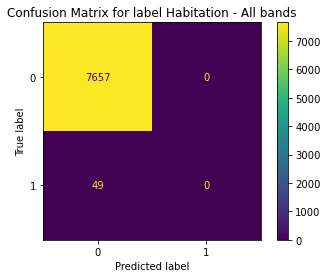

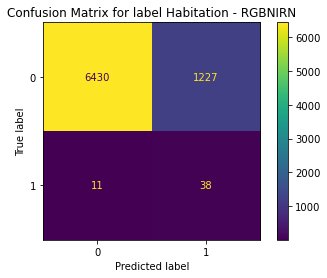

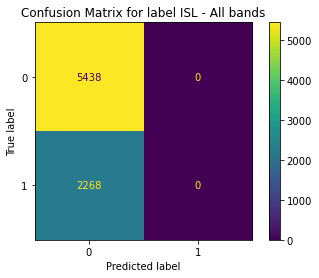

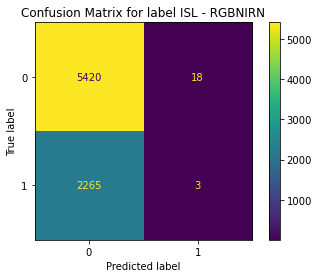

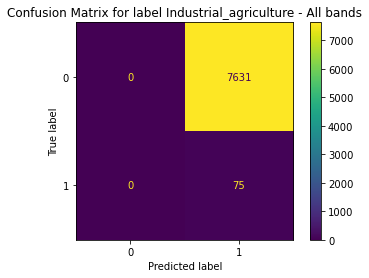

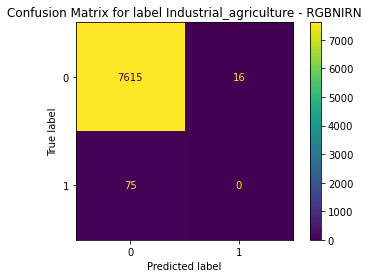

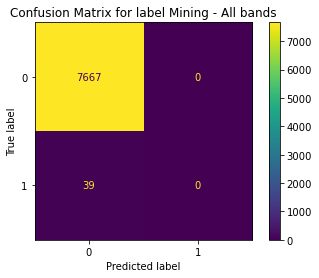

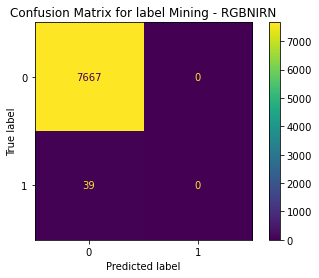

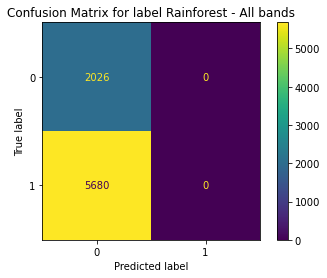

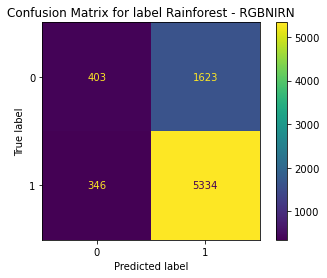

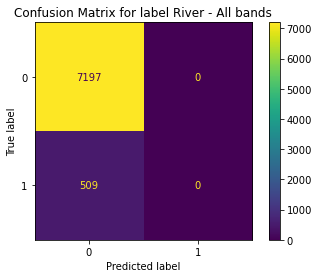

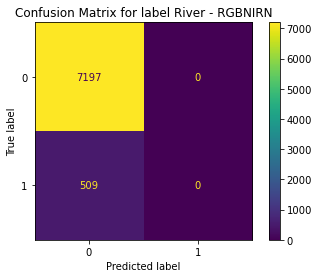

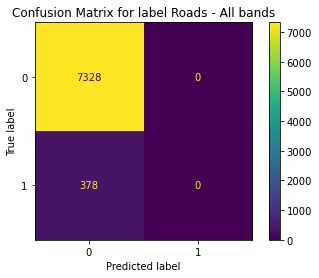

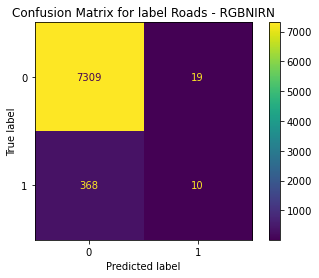

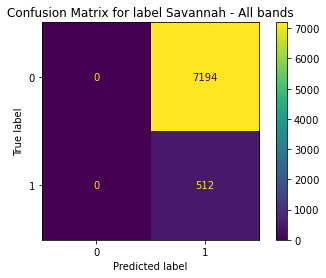

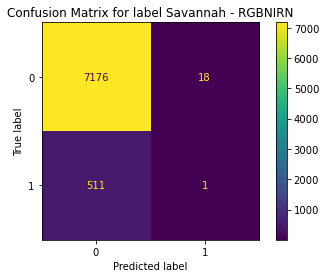

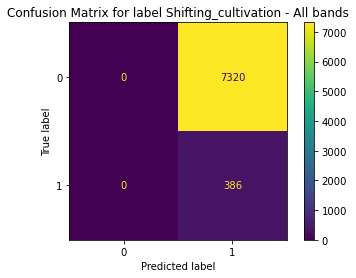

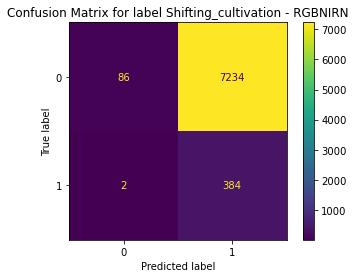

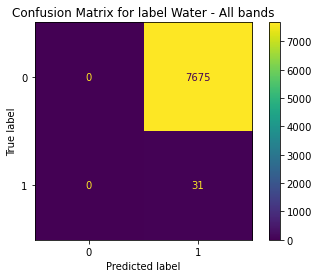

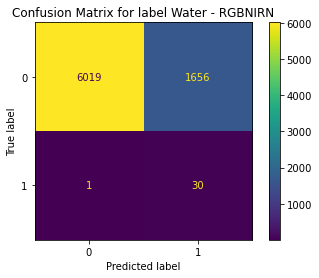

In [29]:
# if no label x on chip i then label = 0 and predicted should = 0 otherwise if label predicted = 1 then it is wrongly classifiying the label (FP)
# if label x on chip i then label = 1 and predicted should = 1 otherwise if label predicted = 0 then it is missing the label classification (FN)
for i in range(len(label_list)):
    cmd = ConfusionMatrixDisplay(matrices_all_bands[i], display_labels=np.unique(y_true)).plot()
    plt.title(f'Confusion Matrix for label {label_list[i]} - All bands')
    plt.show()    
    cmd = ConfusionMatrixDisplay(matrices_RGBNIRN[i], display_labels=np.unique(y_true)).plot()
    plt.title(f'Confusion Matrix for label {label_list[i]} - RGBNIRN')
    plt.show()

In [31]:
KEY = "ckpt/pc-tf-custom-container-test-job-all-ban-2021-03-15-22-50-21-572/model_resnet_epoch_15.h5"
s3 = boto3.resource('s3')
s3.Bucket('canopy-production-ml-output').download_file(KEY, 'model_weights_all_bands.h5')

In [32]:
model_all_bands.load_weights("model_weights_all_bands.h5")

In [34]:
y_pred_all_bands_2 = model_all_bands.predict(gen_all_bands.test_dataset, verbose=1)

7706/7706 [==============================] - 2592s 336ms/step


In [35]:
y_pred_all_bands_threshold_2 = np.where(y_pred_all_bands_2 > threshold, 1, 0)
y_pred_all_bands_threshold_2

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

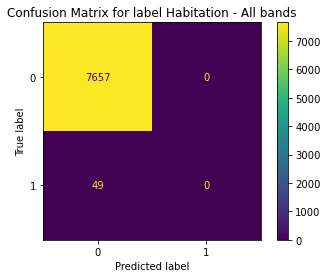

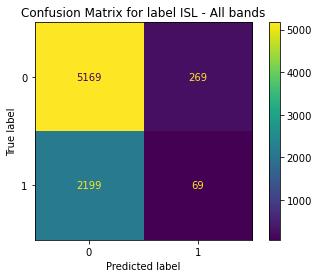

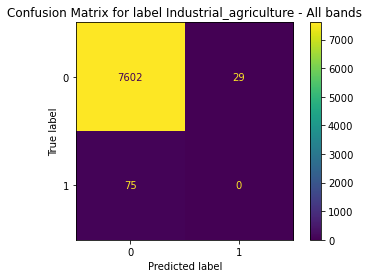

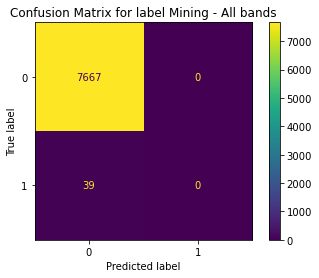

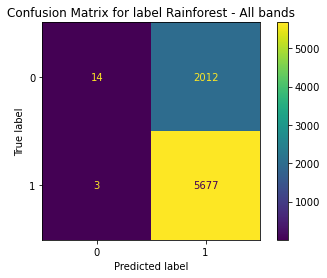

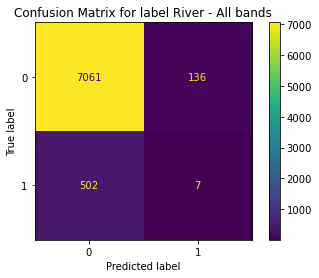

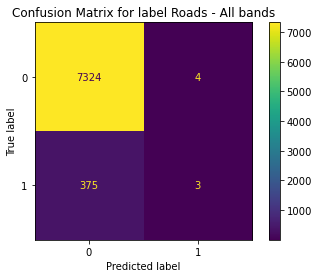

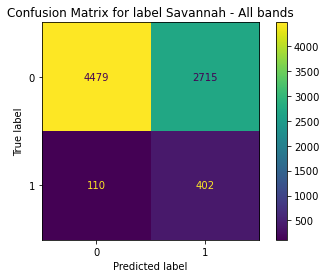

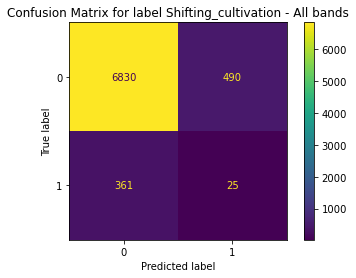

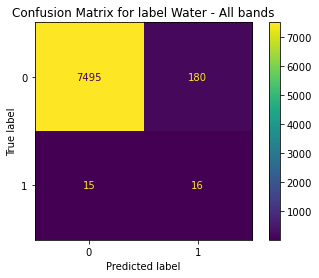

In [36]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html
matrices_all_bands_2 = multilabel_confusion_matrix(y_true, y_pred_all_bands_threshold_2)
for i in range(len(label_list)):
    cmd = ConfusionMatrixDisplay(matrices_all_bands_2[i], display_labels=np.unique(y_true)).plot()
    plt.title(f'Confusion Matrix for label {label_list[i]} - All bands')
    plt.show()    

In [ ]:
loss_all_bands, accuracy_all_bands, precision_all_bands, recall_all_bands, f1score_all_bands = model_all_bands.evaluate(gen_all_bands.test_dataset) 